In [7]:
import numpy as np
from kdg import kdn
from kdg.utils import generate_polynomial, hellinger, plot_2dsim, generate_ood_samples, sample_unifrom_circle, get_ece 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from joblib import Parallel, delayed
from scipy.io import savemat, loadmat
from sklearn.metrics import roc_auc_score
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import activations
from tensorflow.keras import backend as bknd
import timeit

### Visualize the data

<AxesSubplot: >

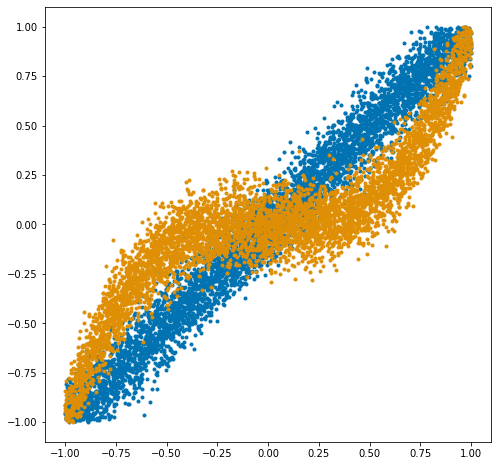

In [8]:
X, y = generate_polynomial(10000, a=(1,3))
plot_2dsim(X, y)

In [9]:
compile_kwargs = {
        "loss": "binary_crossentropy",
        "optimizer": keras.optimizers.Adam(3e-4),
    }
callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10, verbose=True)
fit_kwargs = {
        "epochs": 200,
        "batch_size": 64,
        "verbose": False,
        "callbacks": [callback],
    }

In [10]:
# network architecture [1000, 1000, 1000, 1000, 2]
def getNN(input_size, num_classes):
    network_base = keras.Sequential()
    initializer = keras.initializers.random_normal(seed=0)
    network_base.add(keras.layers.Dense(1000, kernel_initializer=initializer, input_shape=(input_size,)))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(1000, kernel_initializer=initializer))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(1000, kernel_initializer=initializer))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(1000, kernel_initializer=initializer))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(units=num_classes, activation="softmax", kernel_initializer=initializer))
    network_base.compile(**compile_kwargs)
    return network_base

In [11]:
# train Vanilla NN
nn = getNN(input_size=2, num_classes=2)
history = nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)

2023-05-14 10:08:39.074967: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-05-14 10:08:39.223262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 37: early stopping


### Calculate posteriors and likelihoods using KDN

In [7]:
df = {}

t_0 = timeit.default_timer()
model_kdn = kdn(network=nn)
model_kdn.fit(X, y, k=1e9)
t_1 = timeit.default_timer()

print(f"Elapsed time: {t_1-t_0} s")
#define grids
p = np.arange(-2, 2, step=0.01)
q = np.arange(-2, 2, step=0.01)
xx, yy = np.meshgrid(p, q)

grid_samples = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)
posterior_nn = model_kdn.network.predict(grid_samples)
posterior_kdn, likelihoods_kdn = model_kdn.predict_proba(grid_samples, return_likelihood=True)

posterior_nn = posterior_nn[:,0].reshape(400,400)
posterior_kdn = posterior_kdn[:,0].reshape(400,400)
class1_likelihoods = likelihoods_kdn[:,0].reshape(400,400)
class2_likelihoods = likelihoods_kdn[:,1].reshape(400,400)

df['posterior_dn'] = posterior_nn
df['posterior_kdn'] = posterior_kdn
df['likelihood_class1'] = class1_likelihoods
df['likelihood_class2'] = class2_likelihoods

Elapsed time: 586.622358958 s
  77/5000 [..............................] - ETA: 9s 

2023-04-24 23:54:21.539855: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5000/5000 [==============================] - 10s 2ms/step


In [8]:
# get true posterior
tp_df = pd.read_csv("../true_posterior/polynomial_pdf.csv")
proba_true = 0.5*np.ones((400, 400))
tmp = np.array([tp_df["posterior"][x] for x in range(40000)])
tmp = tmp.reshape(200, 200)
proba_true[100:300, 100:300] = tmp

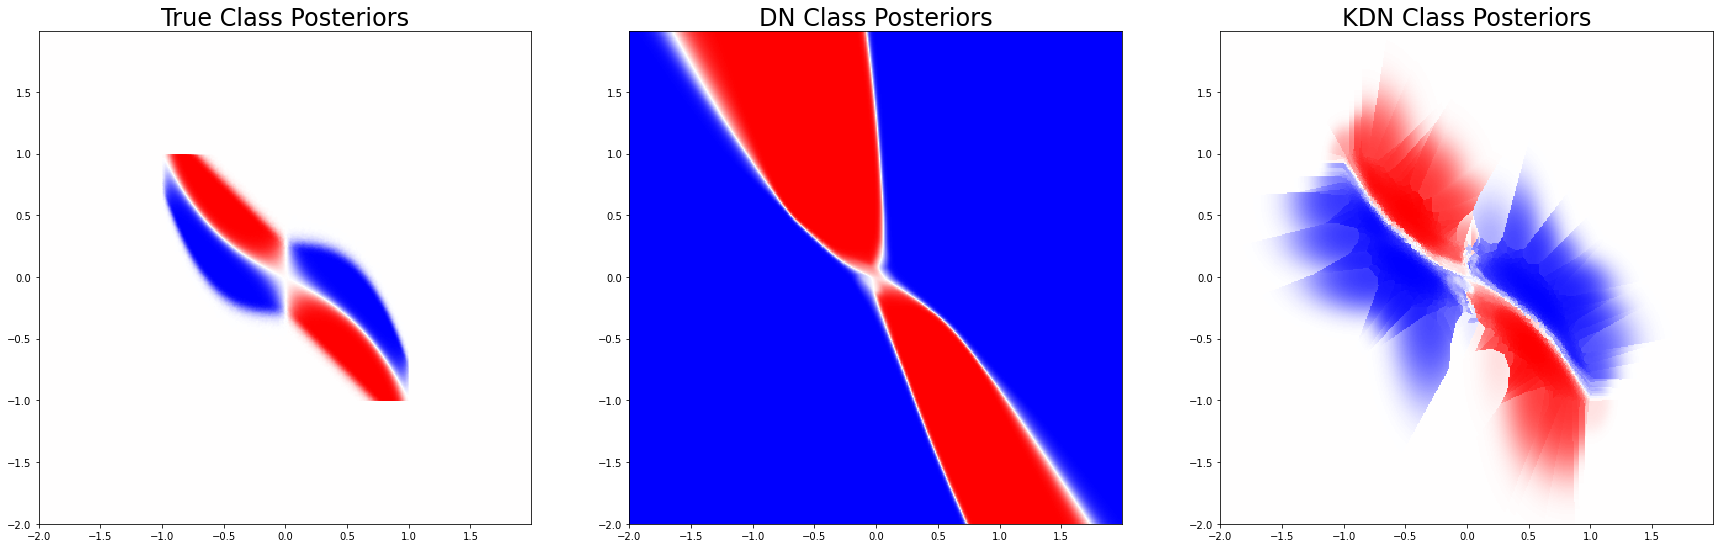

In [9]:
fig1, ax = plt.subplots(1, 3, figsize=(30, 90))

ax0 = ax[0].imshow(
    proba_true,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[0].set_title("True Class Posteriors", fontsize=24)
ax[0].set_aspect("equal")

ax1 = ax[1].imshow(
    posterior_nn,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[1].set_title("DN Class Posteriors", fontsize=24)
ax[1].set_aspect("equal")

ax2 = ax[2].imshow(
    posterior_kdn,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    interpolation="nearest",
    aspect="auto",
)
ax[2].set_title("KDN Class Posteriors", fontsize=24)
ax[2].set_aspect("equal")
plt.show()

### Visualize class likelihoods

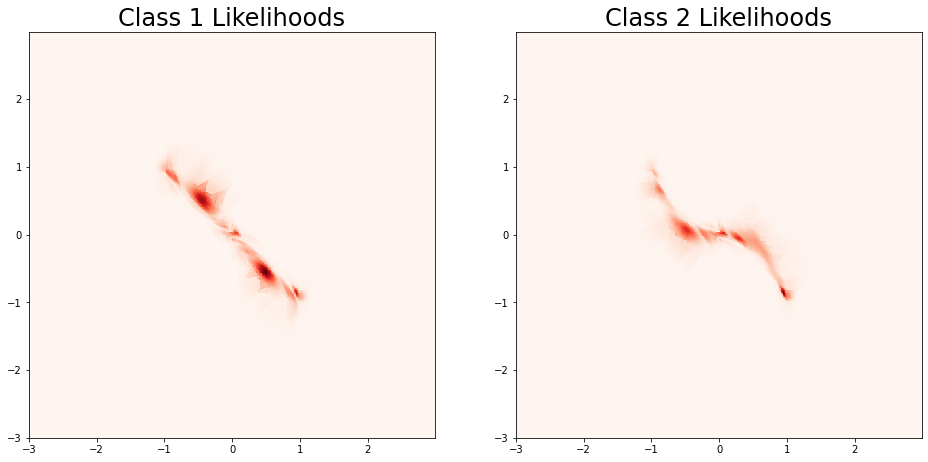

In [14]:
fig1, ax = plt.subplots(1, 2, figsize=(16, 8))

ax0 = ax[0].imshow(
    class1_likelihoods,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="Reds",
    interpolation="nearest",
    aspect="auto",
)
ax[0].set_title("Class 1 Likelihoods", fontsize=24)
ax[0].set_aspect("equal")


ax1 = ax[1].imshow(
    class2_likelihoods,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="Reds",
    interpolation="nearest",
    aspect="auto",
)
ax[1].set_title("Class 2 Likelihoods", fontsize=24)
ax[1].set_aspect("equal")

### Experiment with misclassification error and hellinger distance

In [12]:
mc_reps = 10
sample_size = [50, 100, 500, 1000, 5000, 10000]
n_test = 1000

tp_df = pd.read_csv("../true_posterior/polynomial_pdf.csv")
true_posterior = tp_df['posterior']
true_posterior = np.vstack((1-true_posterior.ravel(), true_posterior.ravel())).T
        
    
def experiment_in(sample, n_test, true_posterior):
    X, y = generate_polynomial(sample, a=(1,3))
    X_test, y_test = generate_polynomial(n_test, a=(1,3)) 
    
    nn = getNN(input_size=2, num_classes=2)
    history = nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)
    model_kdn = kdn(network=nn)
    model_kdn.fit(X, y, k=2e8)
    
    p = np.arange(-1, 1, step=0.01)
    q = np.arange(-1, 1, step=0.01)
    xx, yy = np.meshgrid(p, q)

    grid_samples = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)
    
    proba_dn = model_kdn.network.predict(X_test)
    proba_kdn = model_kdn.predict_proba(X_test)
    predicted_label_dn = np.argmax(proba_dn,axis=1)
    predicted_label_kdn = np.argmax(proba_kdn, axis=1)
    error_kdn = 1 - np.mean(predicted_label_kdn==y_test)   
    error_dn = 1 - np.mean(predicted_label_dn==y_test)
    ece_dn = get_ece(proba_dn, predicted_label_dn, y_test)
    ece_kdn = get_ece(proba_kdn, predicted_label_kdn, y_test)
    
    proba_kdn = model_kdn.predict_proba(grid_samples)
    proba_dn = model_kdn.network.predict(grid_samples)
    hellinger_dis_kdn = hellinger(1-true_posterior, proba_kdn)
    hellinger_dis_dn = hellinger(1-true_posterior, proba_dn)
    mmcIn_dn = np.mean(np.max(proba_dn, axis=1)) 
    mmcIn_kdn = np.mean(np.max(proba_kdn, axis=1))
    
    return error_kdn, error_dn, hellinger_dis_kdn, hellinger_dis_dn, mmcIn_kdn, mmcIn_dn, ece_kdn, ece_dn

def experiment_out(in_sample, r, n_test):
    mmcOut_dn = np.zeros(len(r),dtype=float)
    mmcOut_kdn = np.zeros(len(r),dtype=float)
    
    X, y = generate_polynomial(in_sample, a=(1,3))
    nn = getNN(input_size=2, num_classes=2)
    history = nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)
    
    model_kdn = kdn(network=nn)
    model_kdn.fit(X, y, k=1e3)
    
    for ii, r_ in enumerate(r):
        X_ood = sample_unifrom_circle(n=n_test, r=r_)
        mmcOut_dn[ii] = np.mean(np.max(
            model_kdn.network.predict(X_ood), axis=1
            )
        )
        mmcOut_kdn[ii] = np.mean(np.max(model_kdn.predict_proba(X_ood), axis=1))
    
    return mmcOut_kdn, mmcOut_dn
        
    
error_kdn_med = []
error_kdn_25 = []
error_kdn_75 = []
error_dn_med = []
error_dn_25 = []
error_dn_75 = []
ece_kdn_med = []
ece_kdn_25 = []
ece_kdn_75 = []
ece_dn_med = []
ece_dn_25 = []
ece_dn_75 = []

hellinger_kdn_med = []
hellinger_kdn_25 = []
hellinger_kdn_75 = []
hellinger_dn_med = []
hellinger_dn_25 = []
hellinger_dn_75 = []

mmcIn_kdn_med = []
mmcIn_kdn_25 = []
mmcIn_kdn_75 = []
mmcIn_dn_med = []
mmcIn_dn_25 = []
mmcIn_dn_75 = []

mmcOut_kdn_med = []
mmcOut_kdn_25 = []
mmcOut_kdn_75 = []
mmcOut_dn_med = []
mmcOut_dn_25 = []
mmcOut_dn_75 = []

#### do out-of-distribution results ####
r = np.arange(0,10.5,.5)
mmcOut_kdn = np.zeros((len(r),mc_reps), dtype=float)
mmcOut_dn = np.zeros((len(r),mc_reps), dtype=float)

for rep in range(mc_reps):
    mmcOut_kdn[:,rep], mmcOut_dn[:,rep] = experiment_out(1000, r, n_test)
    
    
    
mmcOut_kdn_med = np.median(mmcOut_kdn, axis=1)
mmcOut_kdn_25 = np.quantile(mmcOut_kdn, [0.25], axis=1)
mmcOut_kdn_75 = np.quantile(mmcOut_kdn, [0.75], axis=1)
    
mmcOut_dn_med = np.median(mmcOut_dn, axis=1)
mmcOut_dn_25 = np.quantile(mmcOut_dn, [0.25], axis=1)
mmcOut_dn_75 = np.quantile(mmcOut_dn, [0.75], axis=1)
    
    
#### do in-distribution results ####
for sample in sample_size:
    res = Parallel(n_jobs=1)(
            delayed(experiment_in)(
                    sample,
                    n_test,
                    true_posterior
                    ) for _ in range(mc_reps)
                )

    
    err_kdn = []
    err_dn = []
    hellinger_kdn = []
    hellinger_dn = []
    mmcIn_kdn = []
    mmcIn_dn = []
    ece_kdn = []
    ece_dn = []
    for ii in range(mc_reps):
        err_kdn.append(res[ii][0])
        err_dn.append(res[ii][1])
        hellinger_kdn.append(res[ii][2])
        hellinger_dn.append(res[ii][3])
        mmcIn_kdn.append(res[ii][4])
        mmcIn_dn.append(res[ii][5])
        ece_kdn.append(res[ii][6])
        ece_dn.append(res[ii][7])

    error_kdn_med.append(
        np.median(err_kdn)
    )
    error_kdn_25.append(
        np.quantile(err_kdn, [0.25])[0]
    )
    error_kdn_75.append(
        np.quantile(err_kdn, [0.75])[0]
    )

    error_dn_med.append(
        np.median(err_dn)
    )
    error_dn_25.append(
        np.quantile(err_dn, [0.25])[0]
    )
    error_dn_75.append(
        np.quantile(err_dn, [0.75])[0]
    )
    ece_dn_med.append(
        np.median(ece_dn)
    )
    ece_dn_25.append(
        np.quantile(ece_dn, [0.25])[0]
    )
    ece_dn_75.append(
        np.quantile(ece_dn, [0.75])[0]
    )
    
    ece_kdn_med.append(
        np.median(ece_kdn)
    )
    ece_kdn_25.append(
        np.quantile(ece_kdn, [0.25])[0]
    )
    ece_kdn_75.append(
        np.quantile(ece_kdn, [0.75])[0]
    )
    
    hellinger_kdn_med.append(
        np.median(hellinger_kdn)
    )
    hellinger_kdn_25.append(
        np.quantile(hellinger_kdn, [0.25])[0]
    )
    hellinger_kdn_75.append(
        np.quantile(hellinger_kdn, [0.75])[0]
    )

    hellinger_dn_med.append(
        np.median(hellinger_dn)
    )
    hellinger_dn_25.append(
        np.quantile(hellinger_dn, [0.25])[0]
    )
    hellinger_dn_75.append(
        np.quantile(hellinger_dn, [0.75])[0]
    )

    mmcIn_kdn_med.append(
        np.median(mmcIn_kdn)
    )
    mmcIn_kdn_25.append(
        np.quantile(mmcIn_kdn, [0.25])[0]
    )
    mmcIn_kdn_75.append(
        np.quantile(mmcIn_kdn, [0.75])[0]
    )

    mmcIn_dn_med.append(
        np.median(mmcIn_dn)
    )
    mmcIn_dn_25.append(
        np.quantile(mmcIn_dn, [0.25])[0]
    )
    mmcIn_dn_75.append(
        np.quantile(mmcIn_dn, [0.75])[0]
    )


df['error_kdn_med'] = error_kdn_med
df['error_kdn_25'] = error_kdn_25
df['error_kdn_75'] = error_kdn_75

df['error_dn_med'] = error_dn_med
df['error_dn_25'] = error_dn_25
df['error_dn_75'] = error_dn_75

df['ece_dn_med'] = ece_dn_med
df['ece_dn_25'] = ece_dn_25
df['ece_dn_75'] = ece_dn_75

df['ece_kdn_med'] = ece_kdn_med
df['ece_kdn_25'] = ece_kdn_25
df['ece_kdn_75'] = ece_kdn_75

df['hellinger_kdn_med'] = hellinger_kdn_med
df['hellinger_kdn_25'] = hellinger_kdn_25
df['hellinger_kdn_75'] = hellinger_kdn_75

df['hellinger_dn_med'] = hellinger_dn_med
df['hellinger_dn_25'] = hellinger_dn_25
df['hellinger_dn_75'] = hellinger_dn_75

df['mmcIn_kdn_med'] = mmcIn_kdn_med
df['mmcIn_kdn_25'] = mmcIn_kdn_25
df['mmcIn_kdn_75'] = mmcIn_kdn_75

df['mmcIn_dn_med'] = mmcIn_dn_med
df['mmcIn_dn_25'] = mmcIn_dn_25
df['mmcIn_dn_75'] = mmcIn_dn_75

df['mmcOut_kdn_med'] = mmcOut_kdn_med
df['mmcOut_kdn_25'] = mmcOut_kdn_25.reshape(-1)
df['mmcOut_kdn_75'] = mmcOut_kdn_75.reshape(-1)

df['mmcOut_dn_med'] = mmcOut_dn_med
df['mmcOut_dn_25'] = mmcOut_dn_25.reshape(-1)
df['mmcOut_dn_75'] = mmcOut_dn_75.reshape(-1)

2023-05-14 10:10:10.238532: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 177: early stopping
32/32 [==============================] - 0s 2ms/step


2023-05-14 10:10:11.745060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 10:10:14.902981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 120: early stopping
32/32 [==============================] - 0s 2ms/step


2023-05-14 10:10:15.943650: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 10:10:19.004639: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-05-14 10:10:20.643143: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 10:10:23.730712: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 126: early stopping
32/32 [==============================] - 0s 2ms/step


2023-05-14 10:10:24.860952: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 10:10:27.910442: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 114: early stopping
32/32 [==============================] - 0s 2ms/step


2023-05-14 10:10:28.952121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 10:10:32.141932: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 155: early stopping
32/32 [==============================] - 0s 2ms/step


2023-05-14 10:10:33.469756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 10:10:36.492076: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-05-14 10:10:38.145466: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 10:10:41.174336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-05-14 10:10:42.840318: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 10:10:45.926366: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 121: early stopping
32/32 [==============================] - 0s 2ms/step


2023-05-14 10:10:47.015621: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 10:10:50.014226: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-05-14 10:10:51.681018: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 10:10:54.743684: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 82: early stopping
32/32 [==============================] - 0s 2ms/step


2023-05-14 10:10:56.219083: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 10:10:59.306101: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 99: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 10:11:00.998524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 10:11:04.122210: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 91: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 10:11:05.805729: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 10:11:08.966590: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 151: early stopping
32/32 [==============================] - 0s 2ms/step


2023-05-14 10:11:11.422682: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 10:11:14.620131: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 75: early stopping
32/32 [==============================] - 0s 2ms/step


2023-05-14 10:11:16.075009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 10:11:19.165563: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 107: early stopping
32/32 [==============================] - 0s 2ms/step


2023-05-14 10:11:21.033608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 10:11:24.078700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 46: early stopping
32/32 [==============================] - 0s 2ms/step


2023-05-14 10:11:25.158336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 10:11:28.241639: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 43: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 10:11:29.306290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 10:11:32.366469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 62: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 10:11:33.700702: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 10:11:36.805230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 52: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 10:11:38.053172: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 10:11:41.240762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 75: early stopping
32/32 [==============================] - 1s 2ms/step


2023-05-14 10:11:47.425527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 10:11:50.722018: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 48: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 10:11:54.929812: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 10:11:58.298676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 64: early stopping
32/32 [==============================] - 0s 2ms/step


2023-05-14 10:12:03.348386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 10:12:06.654903: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 40: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 10:12:10.437997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 10:12:13.771971: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 34: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 10:12:17.408513: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 10:12:20.746329: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 59: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 10:12:25.729595: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 10:12:29.077304: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 48: early stopping
32/32 [==============================] - 0s 2ms/step


2023-05-14 10:12:33.336067: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 10:12:36.684813: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 66: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 10:12:41.915847: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 10:12:45.282677: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 45: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 10:12:49.533990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 10:12:52.827912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 55: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 10:12:57.544095: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 10:13:00.930400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 50: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 10:13:12.044358: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 10:13:15.780649: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 74: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 10:13:29.405086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 10:13:33.137044: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 36: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 10:13:42.854551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 10:13:46.570544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 38: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 10:13:57.182172: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 10:14:01.131969: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 53: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 10:14:12.944094: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 10:14:16.713506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 72: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 10:14:30.402829: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 10:14:34.160480: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 63: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 10:14:47.411858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 10:14:51.082399: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 96: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 10:15:07.347340: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 10:15:11.094368: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 97: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 10:15:27.482418: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 10:15:31.262722: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 41: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 10:15:41.722754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 10:15:45.478411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 70: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 10:18:41.665395: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 10:18:48.284844: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 60: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 10:21:31.040026: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 10:21:37.244805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 70: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 10:24:22.251243: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 10:24:28.455293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 30: early stopping
32/32 [==============================] - 0s 2ms/step


2023-05-14 10:26:53.784515: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 10:26:59.842256: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 35: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 10:29:27.522862: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 10:29:33.876538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 24: early stopping
32/32 [==============================] - 0s 2ms/step


2023-05-14 10:32:05.515344: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 10:32:11.740246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 39: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 10:34:42.458252: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 10:34:48.873820: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 31: early stopping
32/32 [==============================] - 0s 2ms/step


2023-05-14 10:37:24.248260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 10:37:30.763794: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 31: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 10:39:56.173971: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 10:40:02.323384: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 45: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 10:42:42.186664: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 10:42:48.400402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 67: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 10:53:14.349699: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 10:53:23.469039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 46: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 11:03:25.584842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 11:03:35.605802: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 38: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 11:13:32.906657: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 11:13:43.269673: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 48: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 11:24:02.927661: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 11:24:13.536044: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 64: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 11:35:01.644912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 11:35:11.996098: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 72: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 11:45:50.944583: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 11:46:00.788715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 52: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 11:56:13.656773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 11:56:23.240727: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 43: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 12:06:27.193777: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 12:06:37.164829: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 62: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 12:16:58.812772: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-05-14 12:17:08.812406: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 75: early stopping
32/32 [==============================] - 0s 3ms/step


2023-05-14 12:27:43.606552: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


"df['mmcOut_kdn_med'] = mmcOut_kdn_med\ndf['mmcOut_kdn_25'] = mmcOut_kdn_25.reshape(-1)\ndf['mmcOut_kdn_75'] = mmcOut_kdn_75.reshape(-1)\n\ndf['mmcOut_dn_med'] = mmcOut_dn_med\ndf['mmcOut_dn_25'] = mmcOut_dn_25.reshape(-1)\ndf['mmcOut_dn_75'] = mmcOut_dn_75.reshape(-1)"

### Save the result

In [18]:
import pickle
filename = 'results/polynomial.pickle'

with open(filename, 'wb') as f:
    pickle.dump(df,f)

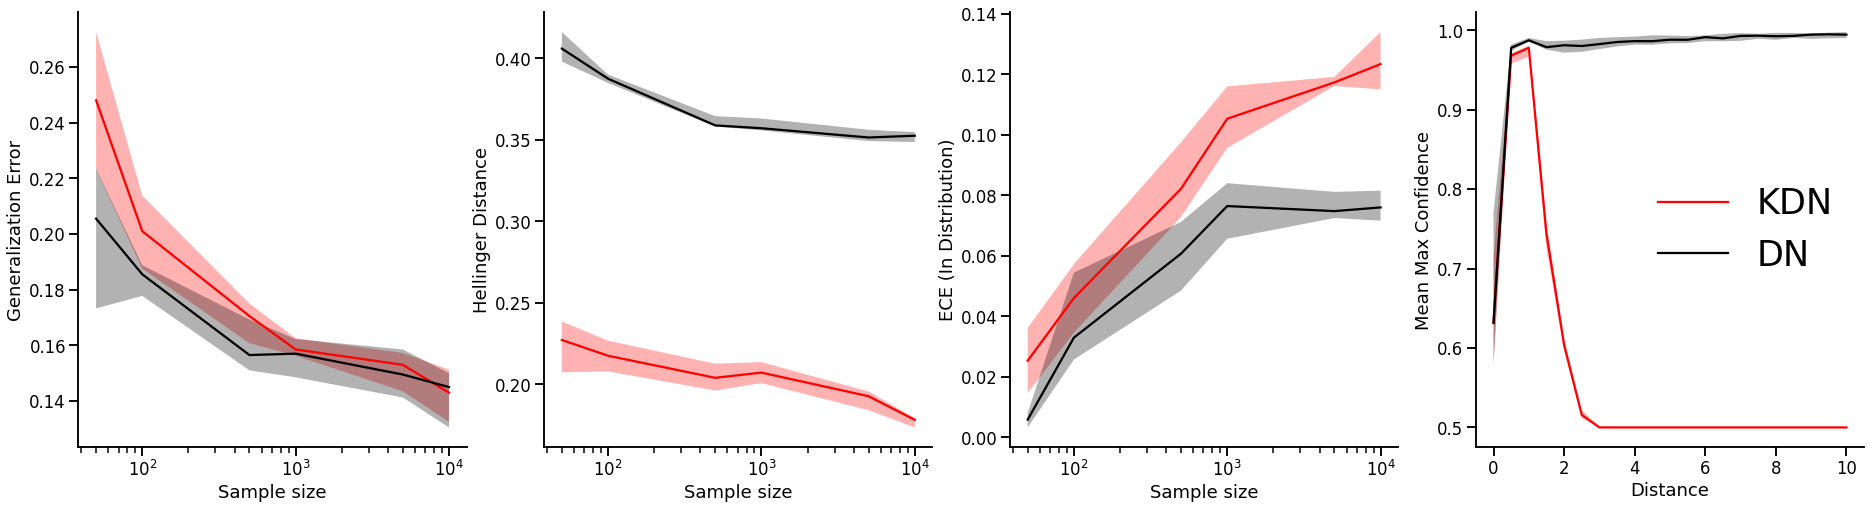

In [17]:
sample_size = [50, 100, 500, 1000, 5000, 10000]

sns.set_context('talk')
fig, ax = plt.subplots(1,4, figsize=(32,8))

ax[0].plot(sample_size, df['error_kdn_med'], c="r", label='KDN')
ax[0].plot(sample_size, df['error_dn_med'], c="k", label='DN')

ax[0].fill_between(sample_size, df['error_kdn_25'], df['error_kdn_75'], facecolor='r', alpha=.3)
ax[0].fill_between(sample_size, df['error_dn_25'], df['error_dn_75'], facecolor='k', alpha=.3)

ax[0].set_xscale('log')
ax[0].set_xlabel('Sample size')
ax[0].set_ylabel('Generalization Error')

right_side = ax[0].spines["right"]
right_side.set_visible(False)
top_side = ax[0].spines["top"]
top_side.set_visible(False)




ax[1].plot(sample_size, df['hellinger_kdn_med'], c="r", label='KDN')
ax[1].plot(sample_size, df['hellinger_dn_med'], c="k", label='DN')

ax[1].fill_between(sample_size, df['hellinger_kdn_25'], df['hellinger_kdn_75'], facecolor='r', alpha=.3)
ax[1].fill_between(sample_size, df['hellinger_dn_25'], df['hellinger_dn_75'], facecolor='k', alpha=.3)

ax[1].set_xscale('log')
ax[1].set_xlabel('Sample size')
ax[1].set_ylabel('Hellinger Distance')

right_side = ax[1].spines["right"]
right_side.set_visible(False)
top_side = ax[1].spines["top"]
top_side.set_visible(False)




ax[2].plot(sample_size, df['ece_kdn_med'], c="r", label='KDN')
ax[2].plot(sample_size, df['ece_dn_med'], c="k", label='DN')
#ax[2].plot(sample_size, df['mmcIn_tree_med'], c="b", label='DT')

ax[2].fill_between(sample_size, df['ece_kdn_25'], df['ece_kdn_75'], facecolor='r', alpha=.3)
ax[2].fill_between(sample_size, df['ece_dn_25'], df['ece_dn_75'], facecolor='k', alpha=.3)

ax[2].set_xscale('log')
ax[2].set_xlabel('Sample size')
ax[2].set_ylabel('ECE (In Distribution)')

right_side = ax[2].spines["right"]
right_side.set_visible(False)
top_side = ax[2].spines["top"]
top_side.set_visible(False)


r = np.arange(0,10.5,.5)
ax[3].plot(r, df['mmcOut_kdn_med'], c="r", label='KDN')
ax[3].plot(r, df['mmcOut_dn_med'], c="k", label='DN')

ax[3].fill_between(r, df['mmcOut_kdn_25'], df['mmcOut_kdn_75'], facecolor='r', alpha=.3)
ax[3].fill_between(r, df['mmcOut_dn_25'], df['mmcOut_dn_75'], facecolor='k', alpha=.3)

#ax[3].set_xscale('log')
ax[3].set_xlabel('Distance')
ax[3].set_ylabel('Mean Max Confidence')

ax[3].legend(fontsize=35, frameon=False)

right_side = ax[3].spines["right"]
right_side.set_visible(False)
top_side = ax[3].spines["top"]
top_side.set_visible(False)